In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
df = pd.read_csv('preprocessed_weather_data.csv')
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])

In [5]:
df.set_index('Formatted Date', inplace=True)

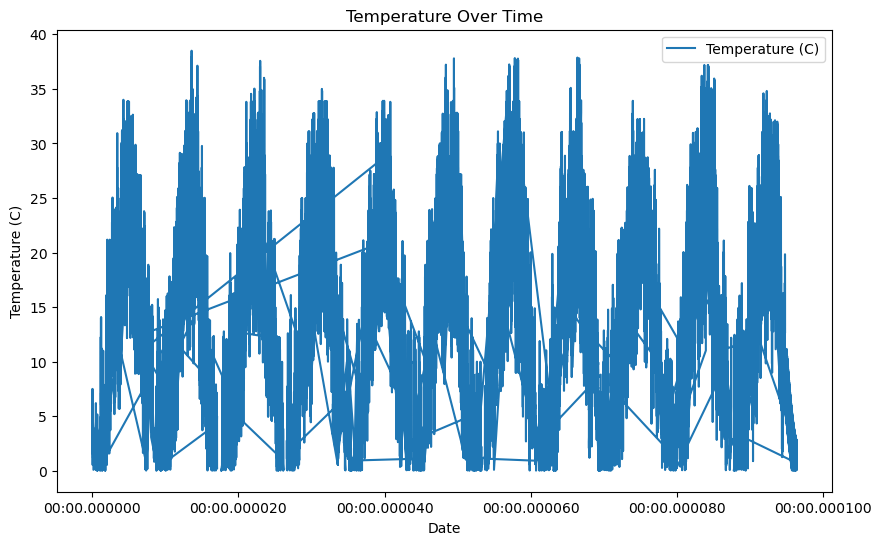

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df['Temperature (C)'], label='Temperature (C)')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

In [7]:
result = adfuller(df['Temperature (C)'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -12.168103188539336
p-value: 1.441623226102247e-22


In [8]:
if result[1] > 0.05:
    print("Data is not stationary. Differencing will be applied.")
    df['Temperature (C)_standardized'] = df['Temperature (C)_standardized'].diff().dropna()

In [9]:
result_diff = adfuller(df['Temperature (C)_standardized'].dropna())
print(f'ADF Statistic (after differencing): {result_diff[0]}')
print(f'p-value (after differencing): {result_diff[1]}')

ADF Statistic (after differencing): -12.16810318853938
p-value (after differencing): 1.4416232261019051e-22


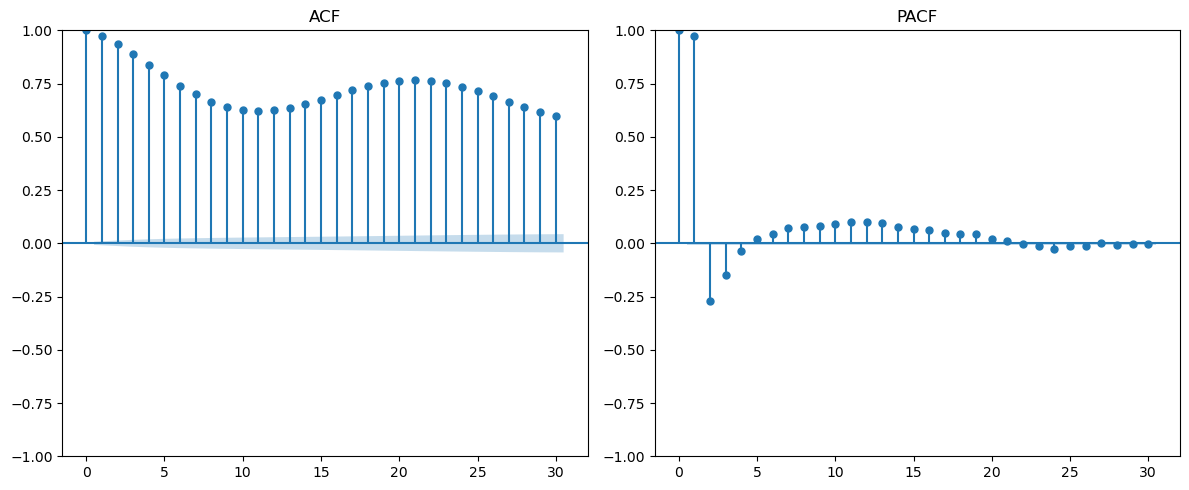

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
 
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(df['Temperature (C)_standardized'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF')
plt.subplot(122)
plot_pacf(df['Temperature (C)_standardized'].dropna(), lags=30, ax=plt.gca())
plt.title('PACF')
plt.tight_layout()
plt.show()

In [11]:
train_size = int(len(df) * 0.8)
train, test = df['Temperature (C)'][:train_size], df['Temperature (C)'][train_size:]
 
# Step 8: Build ARIMA model
p = 1  # Based on ACF and PACF
d = 1  # Based on differencing
q = 1  # Based on ACF and PACF
 
model = ARIMA(train, order=(p, d, q))  # Use chosen parameters
model_fit = model.fit()

c:\Users\NikitaRampurkarV-Sof\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NikitaRampurkarV-Sof\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NikitaRampurkarV-Sof\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NikitaRampurkarV-Sof\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

In [12]:
forecast = model_fit.forecast(steps=len(test))

c:\Users\NikitaRampurkarV-Sof\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NikitaRampurkarV-Sof\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


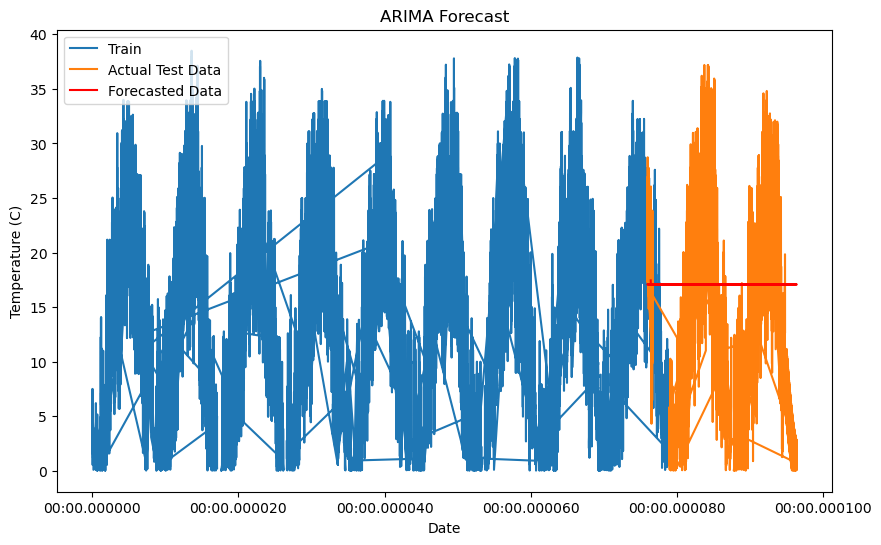

In [13]:
plt.figure(figsize=(10,6))
plt.plot(train, label='Train')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='Forecasted Data', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.show()

In [14]:
# === Training Data (In-sample) ===
train_predictions = model_fit.predict(start=train.index[0], end=train.index[-1])
 
# Calculate MSE, RMSE, MAE, and MAPE for training
train_mse = mean_squared_error(train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train, train_predictions)
train_mape = np.mean(np.abs((train - train_predictions) / train)) * 100
 
# === Testing Data (Out-of-sample) ===
test_mse = mean_squared_error(test, forecast)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test, forecast)
test_mape = np.mean(np.abs((test - forecast) / test)) * 100

C:\Users\NikitaRampurkarV-Sof\AppData\Local\Temp\ipykernel_15200\2819283808.py:14: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  test_mape = np.mean(np.abs((test - forecast) / test)) * 100
C:\Users\NikitaRampurkarV-Sof\AppData\Local\Temp\ipykernel_15200\2819283808.py:14: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  test_mape = np.mean(np.abs((test - forecast) / test)) * 100


In [16]:
print("\nTraining Metrics")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MAPE: {train_mape:.4f}%")
 
print("\nTesting Metrics")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.4f}%")


Training Metrics
Train MSE: 3.3705
Train RMSE: 1.8359
Train MAE: 1.1059
Train MAPE: 28.5499%

Testing Metrics
Test MSE: 77.8559
Test RMSE: 8.8236
Test MAE: 7.3655
Test MAPE: nan%
